# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

In [5]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset ag_news downloaded and prepared to /root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [6]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [7]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [8]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [9]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна.

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие.

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно.

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее.
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству.

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты.
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет.
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

### Запуск базовой модели с семинара на новом датасете (1 балл)

In [10]:
Counter(dataset['train']['label'])

Counter({2: 30000, 3: 30000, 1: 30000, 0: 30000})

In [11]:
class BaseModel(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 2,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")
        
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [12]:
def train(model, optimizer,criterion, epochs):
    eval_steps = len(train_dataloader) // 2

    losses = []
    acc = []


    for epoch in range(epochs):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()
        
        losses.append(sum(epoch_losses) / len(epoch_losses))
        print(f'loss: {losses[-1]:.3f}, acc: {acc[-1]:.3f}')
    return {"losses":losses,"acc":acc, "best_acc":max(acc)}


In [13]:
def plot(losses,acc,best_acc):
    plt.plot(range(len(losses)), losses, label='loss')
    plt.title('loss')
    plt.xlabel("epoch")
    plt.legend()
    plt.show()
    index = acc.index(best_acc)
    plt.plot(list(map(lambda x: x/2,range(len(acc)))), acc, label='acc')
    plt.plot(index/2,best_acc,'ro',label="best") 
    plt.title('acc')
    plt.xlabel("epoch")
    plt.legend()
    plt.show()
    

In [14]:
results = dict()

In [15]:
model_base = BaseModel(
    hidden_dim=256,
    vocab_size=len(vocab),
    num_classes=4,
    aggregation_type='mean',
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_base.parameters())


In [16]:
results['base_model'] = train(model_base,optimizer,criterion, 5)

Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.435, acc: 0.856


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.261, acc: 0.897


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.215, acc: 0.898


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.185, acc: 0.904


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.161, acc: 0.905


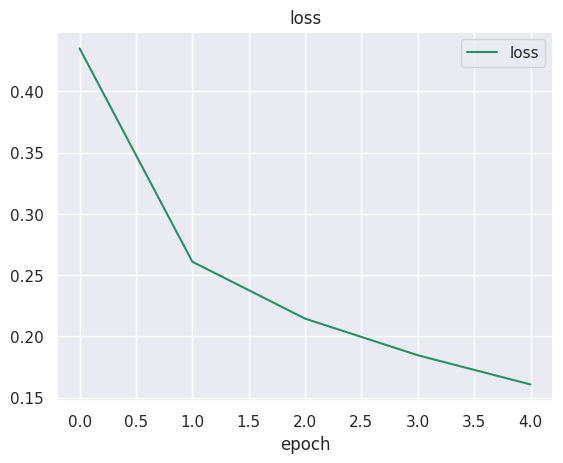

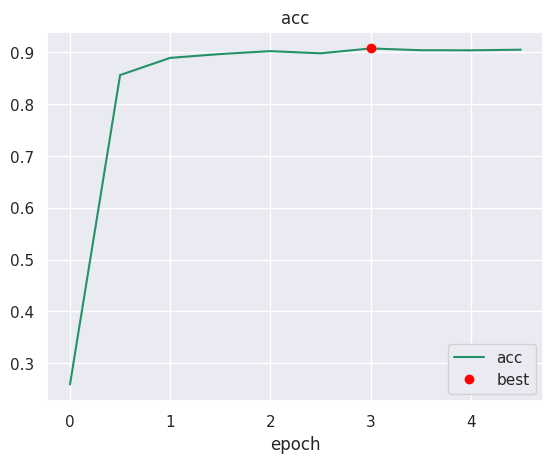

In [17]:
plot(**results['base_model'])

In [18]:
import gc
model_base = None 
optimizer = None
torch.cuda.empty_cache()
gc.collect()

7576

In [19]:
class ConstructorModel(nn.Module):
    def __init__(
        self, 
        hidden_dim: int=256,
        vocab_size: int=len(vocab),
        num_layers: int=2,
        rec_layers:nn.Module = nn.GRU,
        classificator_struct: tuple[tuple[int,int, nn.Module]]=( # знаю,не хорошо использовать ссылочный тип в параметрах
            (128,128, nn.ReLU),
        ),
        dropout_rate: float = 0.1,
        num_classes: int = 4,
        aggregation_type: str = 'mean'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = rec_layers(hidden_dim, hidden_dim, batch_first=True,num_layers=num_layers)
        self.adapter = nn.Linear(hidden_dim, classificator_struct[0][0])
        self.linear = nn.Sequential(*[
            nn.Sequential(
                nn.Linear(param[0], param[1]),
                param[2]()
            )
            for param in classificator_struct
        ])
        self.projection = nn.Linear(classificator_struct[-1][1], num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_rate)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        elif self.aggregation_type == 'sum':
            output = output.sum(dim=1)
        else:
            raise ValueError("Invalid aggregation_type")
        
        output = self.dropout(self.linear(self.adapter(self.non_lin(output))))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.395, acc: 0.875


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.240, acc: 0.904


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.191, acc: 0.907


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.161, acc: 0.913


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.141, acc: 0.908


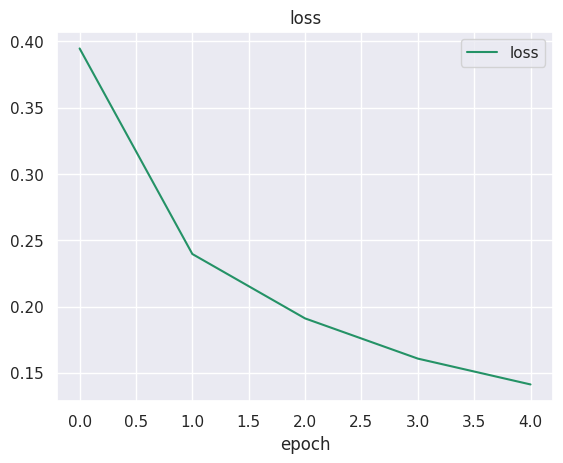

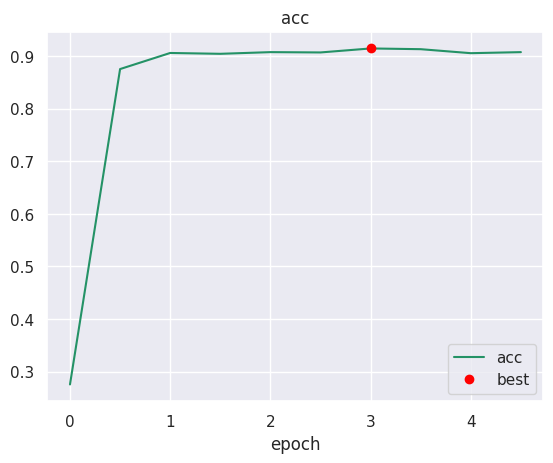

In [20]:
model = ConstructorModel().to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

results['gru_2*256_class_layer_2*128_relu'] = train(model,optimizer,criterion, 5)
plot(**results['gru_2*256_class_layer_2*128_relu'])

In [21]:
import gc
model = None 
optimizer = None
torch.cuda.empty_cache()
gc.collect()

7524

Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.532, acc: 0.875


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.251, acc: 0.909


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.193, acc: 0.910


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.146, acc: 0.907


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.113, acc: 0.907


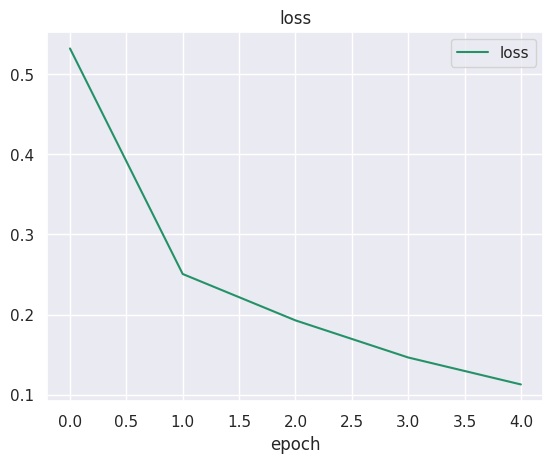

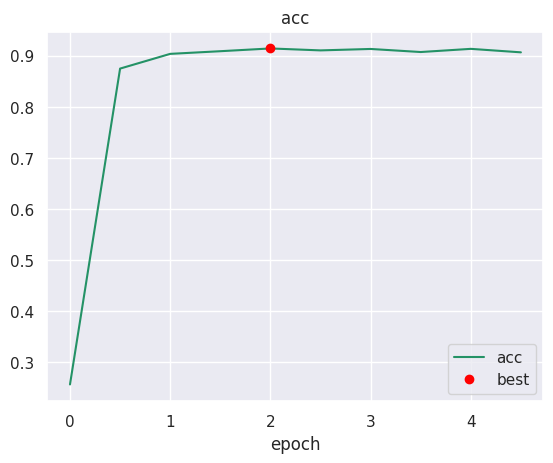

In [22]:
model = ConstructorModel(
    hidden_dim=256,
    vocab_size=len(vocab),
    num_layers=2,
    rec_layers= nn.LSTM,
    classificator_struct=(
        (128,64, nn.ReLU),
        (64,32, nn.ReLU),

    ),
    dropout_rate= 0.1,
    num_classes= 4,
    aggregation_type= 'mean'

).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

results['lstm_2*256_class_layer_128_64_32_relu'] = train(model,optimizer,criterion, 5)
plot(**results['lstm_2*256_class_layer_128_64_32_relu'])

In [23]:
import gc
model = None 
optimizer = None
torch.cuda.empty_cache()
gc.collect()

7396

Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.375, acc: 0.891


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.222, acc: 0.910


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.160, acc: 0.907


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.111, acc: 0.908


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.076, acc: 0.910


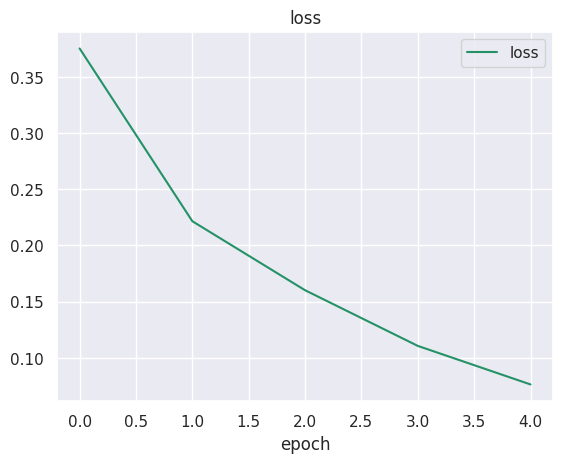

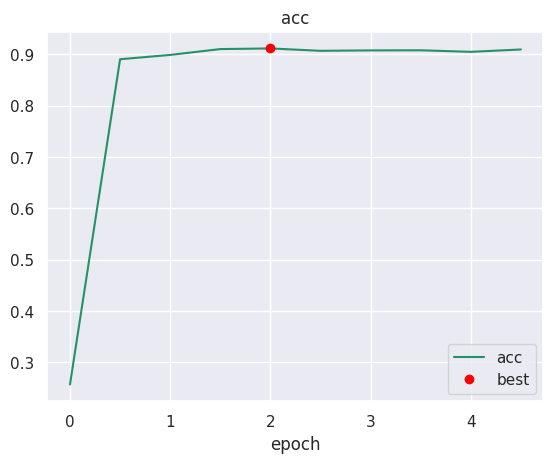

In [24]:
model = ConstructorModel(rec_layers=nn.LSTM,).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

results['lstm_2*256_class_layer_2*128_relu'] = train(model,optimizer,criterion, 5)
plot(**results['lstm_2*256_class_layer_2*128_relu'])

Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.985, acc: 0.475


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.561, acc: 0.837


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.343, acc: 0.876


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.279, acc: 0.885


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.242, acc: 0.901


Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.215, acc: 0.903


Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.192, acc: 0.902


Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.171, acc: 0.903


Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.153, acc: 0.906


Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.135, acc: 0.906


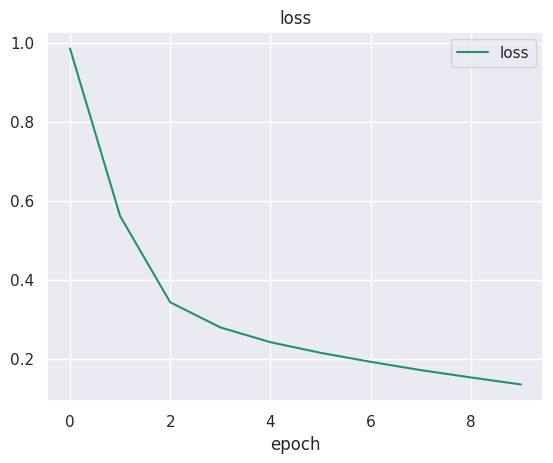

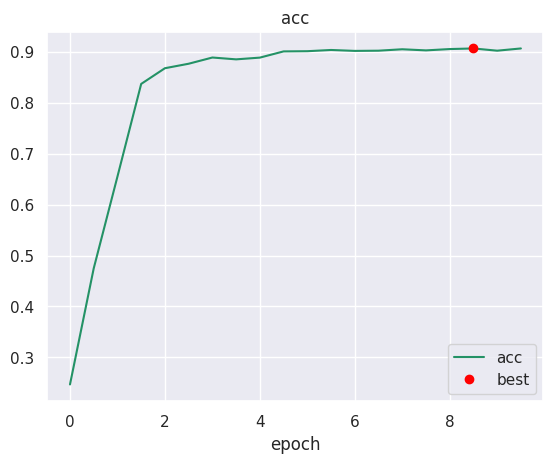

In [25]:
model = ConstructorModel(
    hidden_dim=256,
    vocab_size=len(vocab),
    num_layers=2,
    rec_layers= nn.LSTM,
    classificator_struct=(
        (128,64, nn.ReLU),
        (64,32, nn.ReLU),

    ),
    dropout_rate= 0.1,
    num_classes= 4,
    aggregation_type= 'mean'

).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)

results['lstm_2*256_class_layer_128_64_32_relu_lr1e-4'] = train(model,optimizer,criterion, 10)
plot(**results['lstm_2*256_class_layer_128_64_32_relu_lr1e-4'])

In [26]:
import gc
model = None 
optimizer = None
torch.cuda.empty_cache()
gc.collect()

10776

Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 1.388, acc: 0.247


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 1.386, acc: 0.247


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 1.386, acc: 0.257


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 1.386, acc: 0.247


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 1.386, acc: 0.265


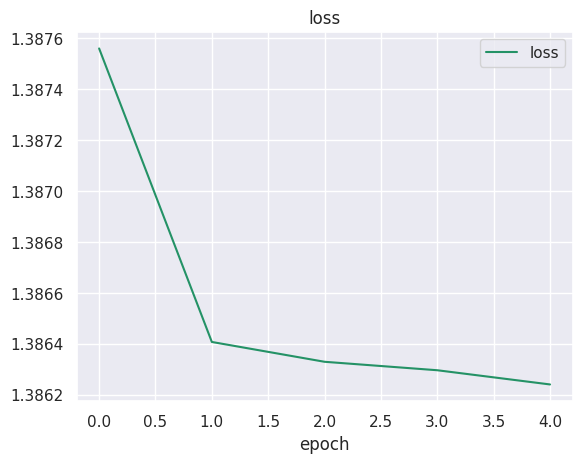

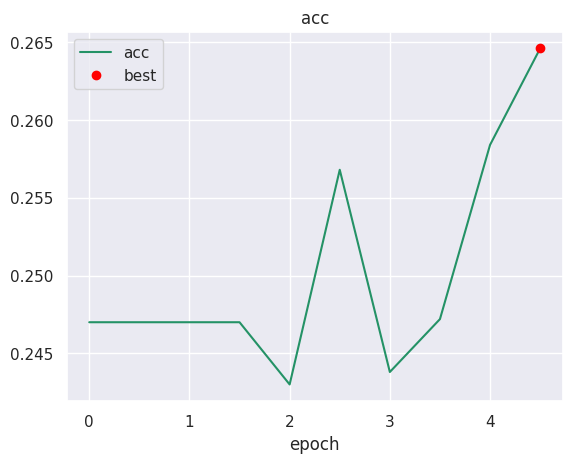

In [27]:
model = ConstructorModel(
    hidden_dim=256,
    vocab_size=len(vocab),
    num_layers=2,
    rec_layers= nn.LSTM,
    classificator_struct=(
        (128,64, nn.ReLU),
        (64,32, nn.ReLU),

    ),
    dropout_rate= 0.1,
    num_classes= 4,
    aggregation_type= 'mean'

).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.SGD(model.parameters(),lr=0.001)

results['lstm_2*256_class_layer_128_64_32_relu_sgd'] = train(model,optimizer,criterion, 5)
plot(**results['lstm_2*256_class_layer_128_64_32_relu_sgd'])

In [28]:
import gc
model = None 
optimizer = None
torch.cuda.empty_cache()
gc.collect()

7498

In [29]:
def train_scheduler(model, optimizer,criterion, epochs,scheduler=None):
    eval_steps = len(train_dataloader) // 2

    losses = []
    acc = []


    for epoch in range(epochs):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()
        
        losses.append(sum(epoch_losses) / len(epoch_losses))
        print(f'loss: {losses[-1]:.3f}, acc: {acc[-1]:.3f}')
        if scheduler is not None:
            scheduler.step()
    return {"losses":losses,"acc":acc, "best_acc":max(acc)}


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.494, acc: 0.867


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.250, acc: 0.910


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.190, acc: 0.913


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.141, acc: 0.908


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.107, acc: 0.913


Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.083, acc: 0.909


Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.068, acc: 0.905


Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.058, acc: 0.898


Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.051, acc: 0.904


Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.044, acc: 0.895


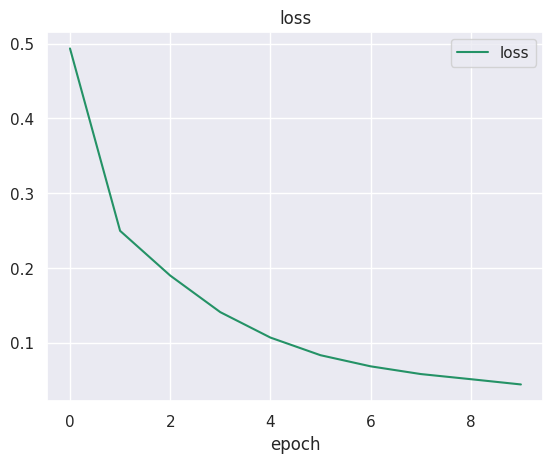

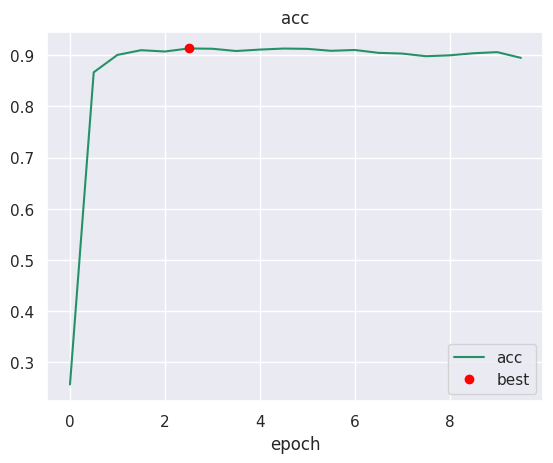

In [30]:


model = ConstructorModel(
    hidden_dim=256,
    vocab_size=len(vocab),
    num_layers=2,
    rec_layers= nn.LSTM,
    classificator_struct=(
        (128,64, nn.ReLU),
        (64,32, nn.ReLU),

    ),
    dropout_rate= 0.1,
    num_classes= 4,
    aggregation_type= 'mean'

).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

lambda1 = lambda epoch: 0.99 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

results['lstm_2*256_class_layer_128_64_32_relu_lr_scheduler'] = train_scheduler(model,optimizer,criterion, 10,scheduler)
plot(**results['lstm_2*256_class_layer_128_64_32_relu_lr_scheduler'])

In [31]:
import gc
model = None 
optimizer = None
torch.cuda.empty_cache()
gc.collect()

3734

Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.438, acc: 0.889


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.243, acc: 0.909


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.182, acc: 0.914


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.136, acc: 0.910


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.099, acc: 0.907


Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.075, acc: 0.911


Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.058, acc: 0.913


Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.048, acc: 0.908


Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.040, acc: 0.910


Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.033, acc: 0.909


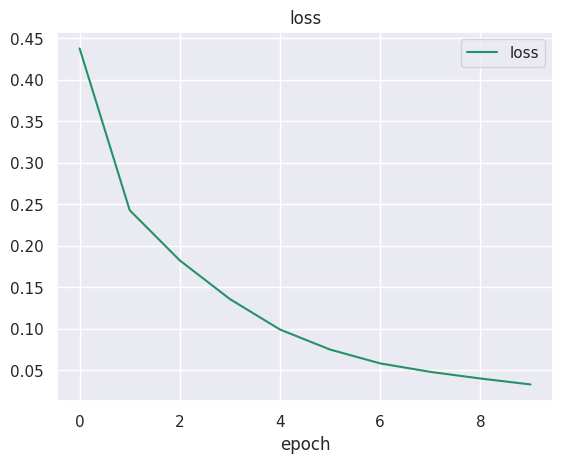

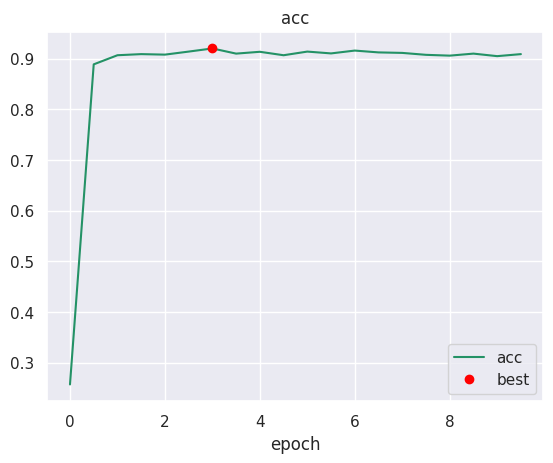

In [32]:
model = ConstructorModel(
    hidden_dim=256,
    vocab_size=len(vocab),
    num_layers=2,
    rec_layers= nn.LSTM,
    classificator_struct=(
        (128,64, nn.ReLU),
        (64,32, nn.ReLU),

    ),
    dropout_rate= 0.1,
    num_classes= 4,
    aggregation_type= 'mean'

).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

lambda1 = lambda epoch: 0.95 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

results['lstm_2*256_class_layer_128_64_32_relu_lr_scheduler_95'] = train_scheduler(model,optimizer,criterion, 10,scheduler)
plot(**results['lstm_2*256_class_layer_128_64_32_relu_lr_scheduler_95'])

In [33]:
import gc
model = None 
optimizer = None
torch.cuda.empty_cache()
gc.collect()

3711

Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.443, acc: 0.890


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.298, acc: 0.905


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.284, acc: 0.898


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.269, acc: 0.900


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.261, acc: 0.907


Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.260, acc: 0.901


Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.257, acc: 0.905


Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.251, acc: 0.909


Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.250, acc: 0.905


Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.244, acc: 0.905


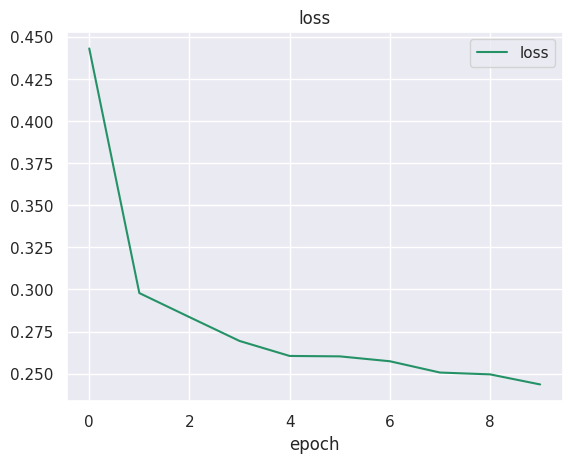

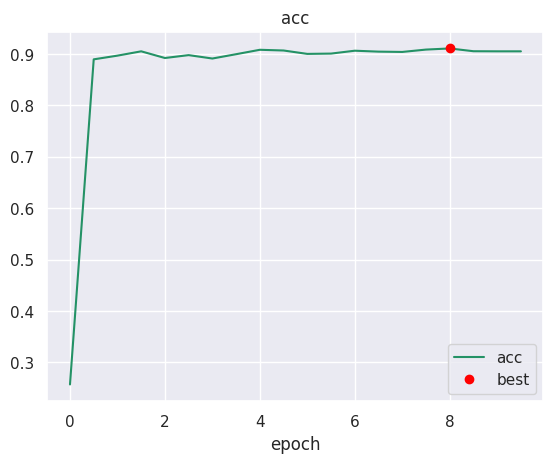

In [34]:
model = ConstructorModel(
    hidden_dim=256,
    vocab_size=len(vocab),
    num_layers=2,
    rec_layers= nn.LSTM,
    classificator_struct=(
        (128,64, nn.ReLU),
        (64,32, nn.ReLU),

    ),
    dropout_rate= 0.1,
    num_classes= 4,
    aggregation_type= 'sum'

).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

lambda1 = lambda epoch: 0.99 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

results['lstm_2*256_class_layer_128_64_32_relu_sum_scheduler'] = train_scheduler(model,optimizer,criterion, 10,scheduler)
plot(**results['lstm_2*256_class_layer_128_64_32_relu_sum_scheduler'])


In [35]:
import gc
model = None 
optimizer = None
torch.cuda.empty_cache()
gc.collect()

3738

Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.771, acc: 0.671


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.329, acc: 0.895


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.268, acc: 0.900


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.230, acc: 0.910


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.204, acc: 0.912


Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.174, acc: 0.912


Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.151, acc: 0.908


Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.131, acc: 0.904


Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.119, acc: 0.901


Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.109, acc: 0.903


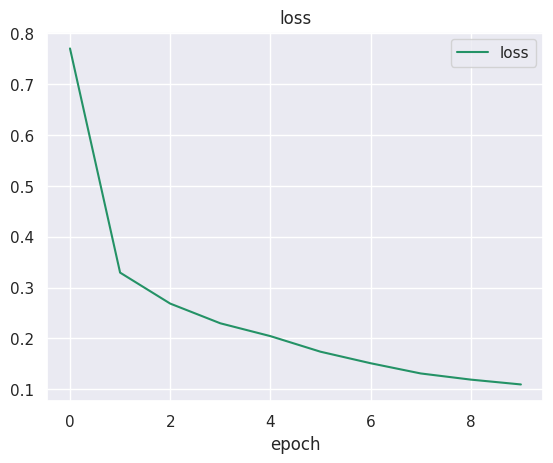

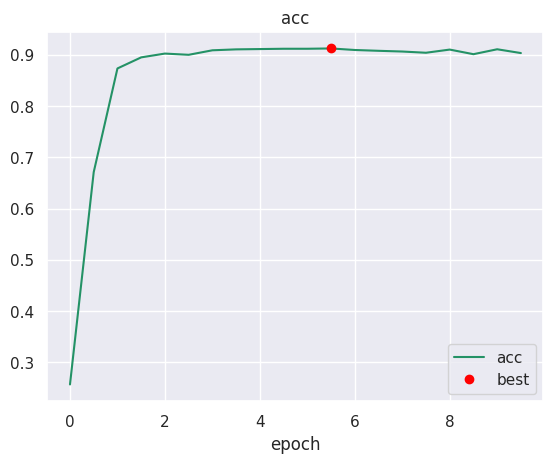

In [36]:


model = ConstructorModel(
    hidden_dim=256,
    vocab_size=len(vocab),
    num_layers=3,
    rec_layers= nn.LSTM,
    classificator_struct=(
        (128,64, nn.ReLU),
        (64,32, nn.ReLU),
        (32,16, nn.ReLU),


    ),
    dropout_rate= 0.1,
    num_classes= 4,
    aggregation_type= 'sum'

).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

lambda1 = lambda epoch: 0.99 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

results['lstm_2*256_class_layer_128_64_32_16_relu_sum_lr_scheduler'] = train_scheduler(model,optimizer,criterion, 10,scheduler)
plot(**results['lstm_2*256_class_layer_128_64_32_16_relu_sum_lr_scheduler'])

In [37]:
import gc
model = None 
optimizer = None
torch.cuda.empty_cache()
gc.collect()

3716

Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.526, acc: 0.872


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.365, acc: 0.889


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.354, acc: 0.883


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.339, acc: 0.893


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.342, acc: 0.887


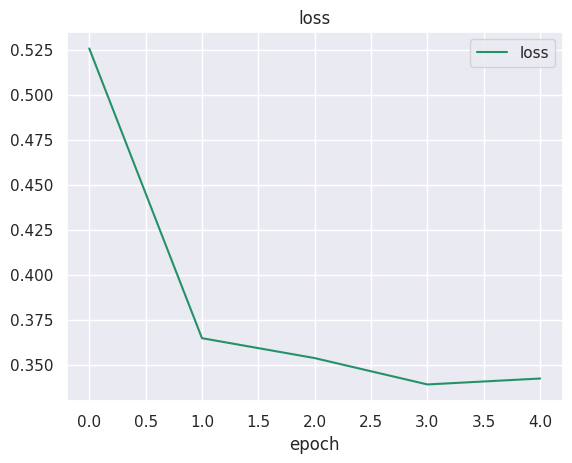

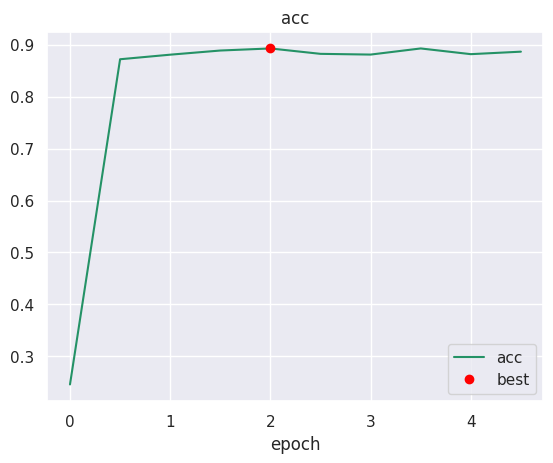

In [38]:


model = ConstructorModel(
    hidden_dim=256,
    vocab_size=len(vocab),
    num_layers=2,
    rec_layers= nn.LSTM,
    classificator_struct=(
        (128,64, nn.ReLU),
        (64,16, nn.ReLU),


    ),
    dropout_rate= 0.1,
    num_classes= 4,
    aggregation_type= 'sum'

).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

# lambda1 = lambda epoch: 0.99 ** epoch
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

results['lstm_2*256_class_layer_128_64_16_relu_sum'] = train(model,optimizer,criterion, 5)
plot(**results['lstm_2*256_class_layer_128_64_16_relu_sum'])

In [39]:
import gc
model = None 
optimizer = None
torch.cuda.empty_cache()
gc.collect()

7724

In [40]:
def plot_results(results):
    for name, value in results.items():
        plt.plot(range(len(value['losses'])), value['losses'], label=name)
    plt.title('loss')
    plt.xlabel("epoch")
    plt.legend()
    plt.show()
    
    for name, value in results.items():
        index = value['acc'].index(value['best_acc'])
        plt.plot(list(map(lambda x: x/2,range(len(value['acc'])))), value['acc'], label=name)
        plt.plot(index/2,value['best_acc'],'ro',label=f'best {name}') 
    plt.title('acc')
    plt.xlabel("epoch")
    plt.legend()
    plt.show()
    print('best acc!!!!!!!!!!!!!!!!!!!!!')
    for name, value in results.items():
        print(name, value['best_acc'])
    

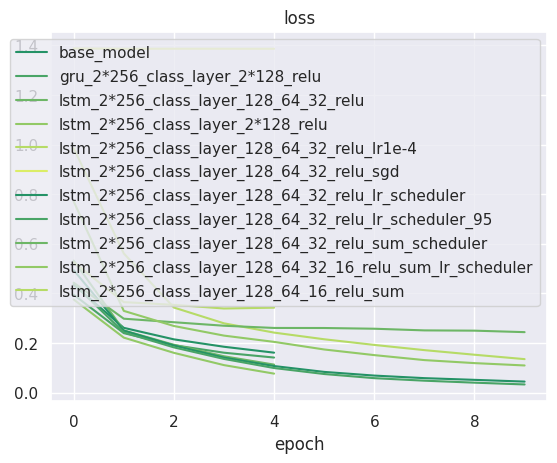

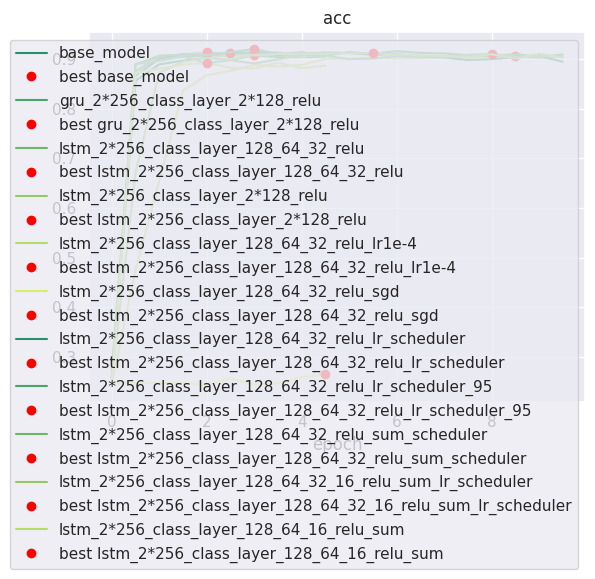

best acc!!!!!!!!!!!!!!!!!!!!!
base_model 0.9077999591827393
gru_2*256_class_layer_2*128_relu 0.9145999550819397
lstm_2*256_class_layer_128_64_32_relu 0.914199948310852
lstm_2*256_class_layer_2*128_relu 0.9115999937057495
lstm_2*256_class_layer_128_64_32_relu_lr1e-4 0.9063999652862549
lstm_2*256_class_layer_128_64_32_relu_sgd 0.2645999789237976
lstm_2*256_class_layer_128_64_32_relu_lr_scheduler 0.9133999943733215
lstm_2*256_class_layer_128_64_32_relu_lr_scheduler_95 0.9203999638557434
lstm_2*256_class_layer_128_64_32_relu_sum_scheduler 0.9107999801635742
lstm_2*256_class_layer_128_64_32_16_relu_sum_lr_scheduler 0.9121999740600586
lstm_2*256_class_layer_128_64_16_relu_sum 0.8930000066757202


In [41]:

plot_results(results)